The following are examples of FEDOT timeseries gap filling and predictions. Examples are from:<br>
https://github.com/ITMO-NSS-team/fedot-examples/blob/main/notebooks/latest/5_ts_specific_cases.ipynb

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

import logging

In [2]:
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.utilities.ts_gapfilling import ModelGapFiller, SimpleGapFiller

import logging

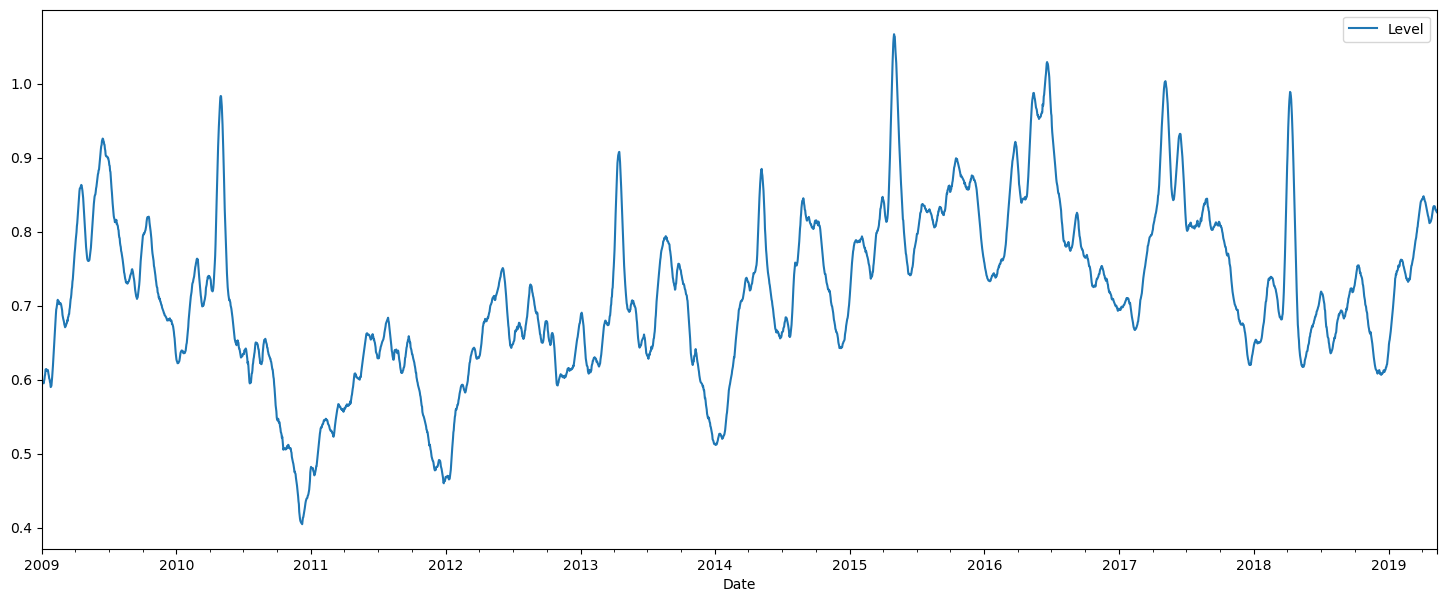

In [8]:
df = pd.read_csv('data/ts_sea_level.csv')
df['Date'] = pd.to_datetime(df['Date'])

df.plot('Date', 'Level')
plt.show()

In [8]:
def plot_results(actual_time_series, predicted_values, len_train_data, y_name = 'Parameter'):
    """
    Function for drawing plot with predictions
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()

In [9]:
# Specify forecast length
forecast_length = 200

# Got univariate time series as numpy array
time_series = np.array(df['Level'])

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))
input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series,
                       target=time_series,
                       task=task,
                       data_type=DataTypesEnum.ts)

# Split data into train and test
train_input, predict_input = train_test_data_setup(input_data)

In [14]:
def get_pipeline():
    node_lagged_1 = PrimaryNode('lagged')
    node_lagged_1.parameters = {'window_size': 120}
    node_lagged_2 = PrimaryNode('lagged')
    node_lagged_2.parameters = {'window_size': 10}

    node_first = SecondaryNode('ridge', nodes_from=[node_lagged_1])
    node_second = SecondaryNode('dtreg', nodes_from=[node_lagged_2])
    node_final = SecondaryNode('ridge', nodes_from=[node_first, node_second])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_pipeline()

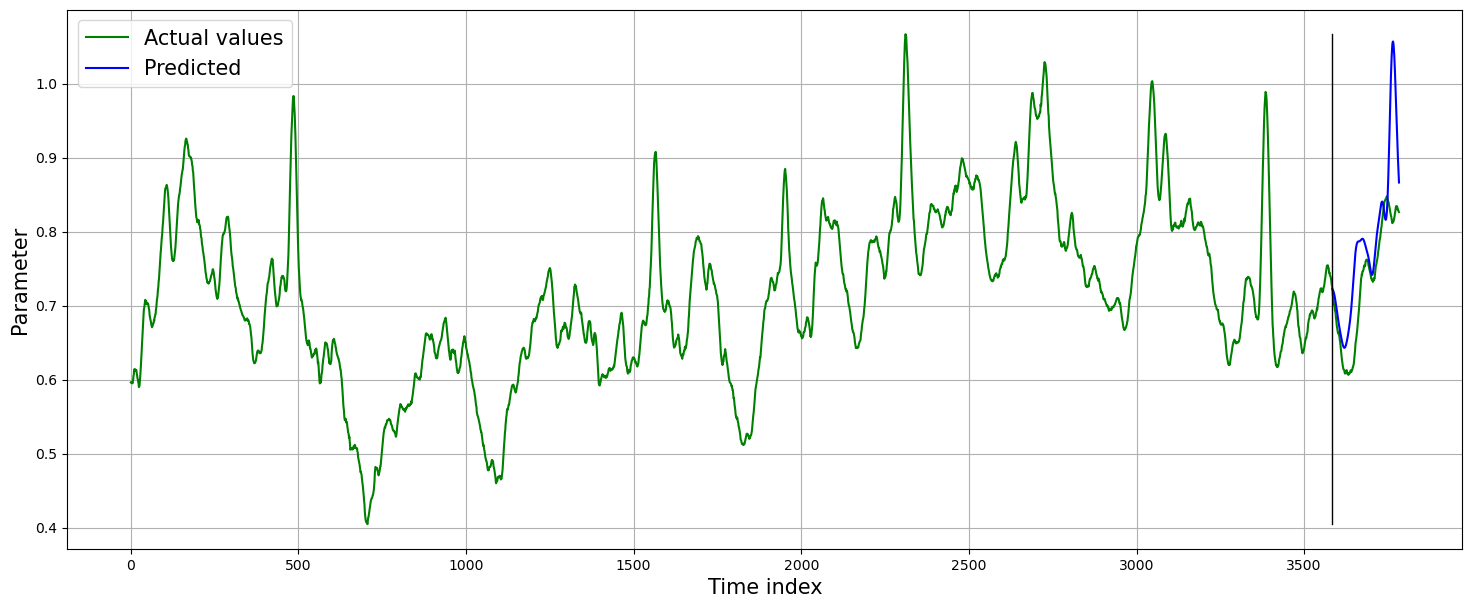

In [15]:
# Fit pipeline
pipeline.fit(train_input)

# Make forecast
output = pipeline.predict(predict_input)
forecast = np.ravel(np.array(output.predict))

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = forecast, 
             len_train_data = len(time_series)-forecast_length)

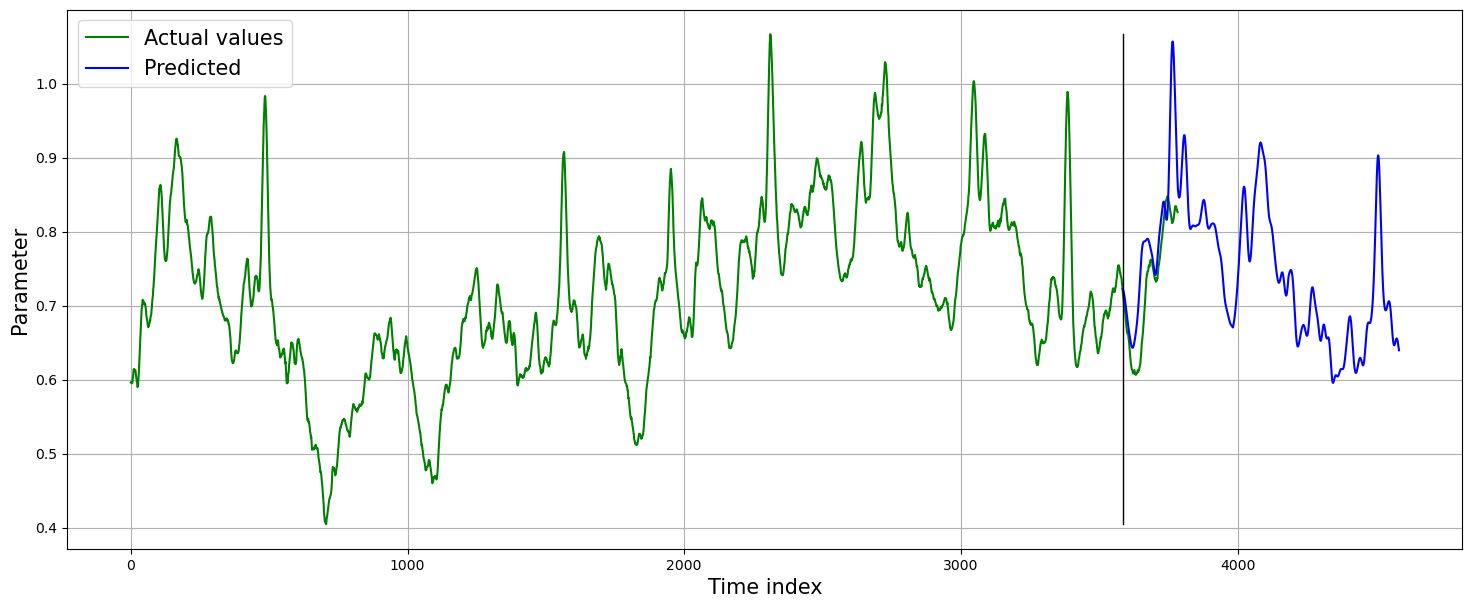

In [16]:
from fedot.core.pipelines.ts_wrappers import out_of_sample_ts_forecast

# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=predict_input,
                                         horizon=1000)

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = ts_predicted, 
             len_train_data = len(time_series)-forecast_length)

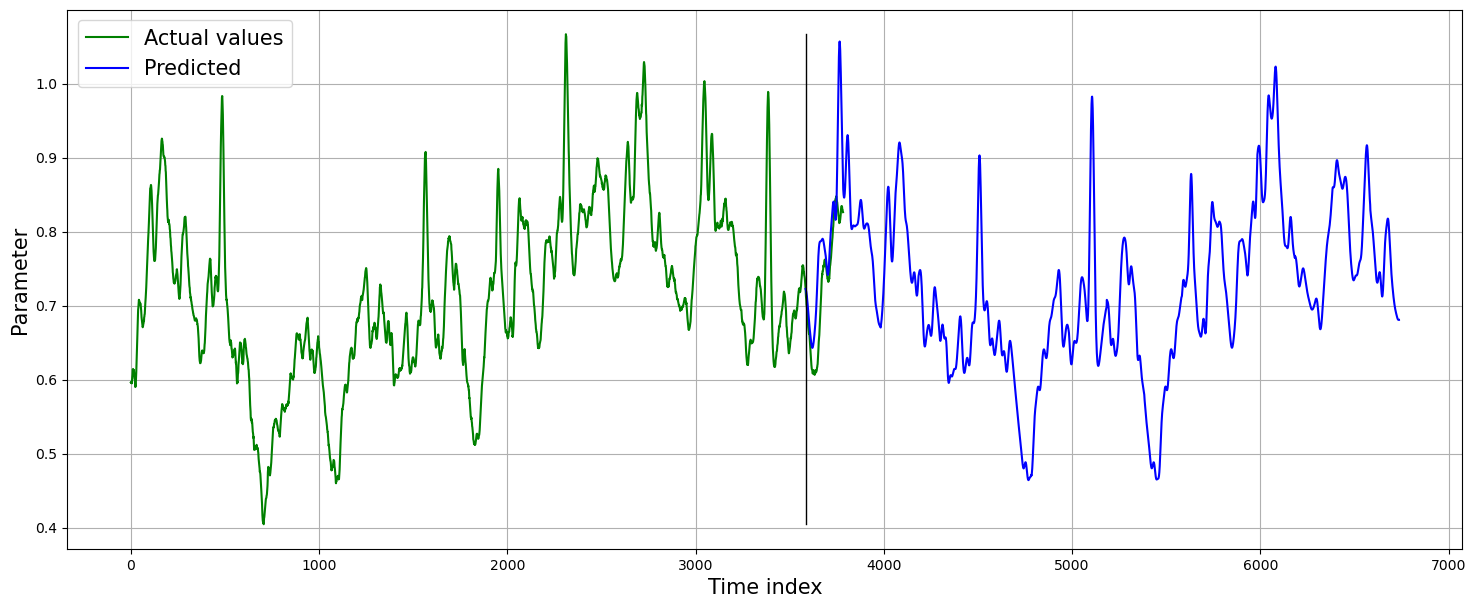

In [17]:
# Make forecast
ts_predicted = out_of_sample_ts_forecast(pipeline=pipeline,
                                         input_data=predict_input,
                                         horizon=3153)

# Plot the graph
plot_results(actual_time_series = time_series,
             predicted_values = ts_predicted, 
             len_train_data = len(time_series)-forecast_length)

In [18]:
def generate_gaps_in_ts(array_without_gaps, gap_dict, gap_value):
    """
    Function for generating gaps with predefined length in the desired indices
    of an one-dimensional array (time series)

    :param array_without_gaps: an array without gaps
    :param gap_dict: a dictionary with omissions, where the key is the index in
    the time series from which the gap will begin. The key value is the length
    of the gap (elements). -1 in the value means that a skip is generated until
    the end of the array
    :param gap_value: value indicating a gap in the array

    :return: one-dimensional array with omissions
    """

    array_with_gaps = np.copy(array_without_gaps)

    keys = list(gap_dict.keys())
    for key in keys:
        gap_size = gap_dict.get(key)
        if gap_size == -1:
            # Generating a gap to the end of an array
            array_with_gaps[key:] = gap_value
        else:
            array_with_gaps[key:(key + gap_size)] = gap_value

    return array_with_gaps

# Generate gaps
gap_dict = {1350: 150,
            2600: 250}
array_with_gaps = generate_gaps_in_ts(array_without_gaps=time_series,
                                      gap_dict=gap_dict,
                                      gap_value=-100.0)

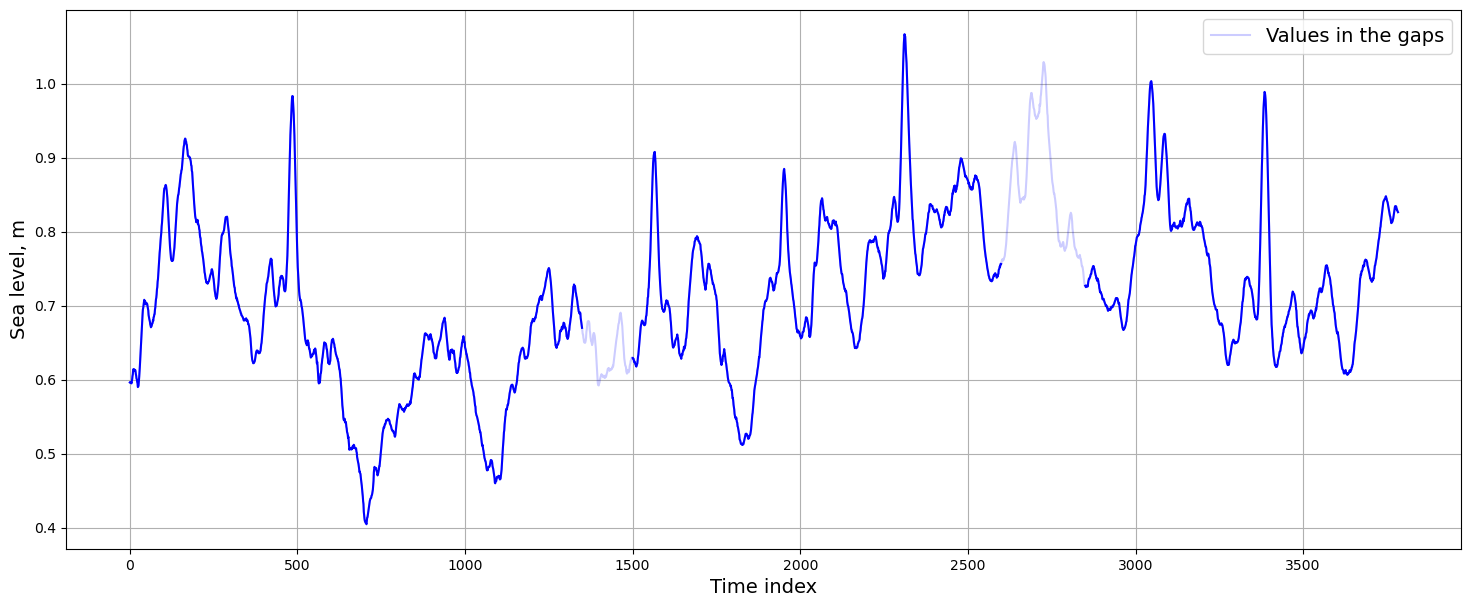

In [19]:
# Make masked array for visualisation
masked_array = np.ma.masked_where(array_with_gaps == -100.0, array_with_gaps)

# Plot time series with gaps
plt.plot(time_series, c='blue', alpha=0.2, label='Values in the gaps')
plt.plot(masked_array, c='blue', alpha=1.0)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [21]:
# Define SimpleGapFiller object
simple_gapfill = SimpleGapFiller(gap_value=-100.0)

# Local polynomial approximation (Savitzky–Golay filters)
without_gap_poly_1 = simple_gapfill.local_poly_approximation(array_with_gaps, 
                                                             degree=2, 
                                                             n_neighbors=200)

# Batch polynomial approximation
without_gap_poly_2 = simple_gapfill.batch_poly_approximation(array_with_gaps, 
                                                             degree=10, 
                                                             n_neighbors=1000)

# Linear interpolation
without_gap_linear = simple_gapfill.linear_interpolation(array_with_gaps)

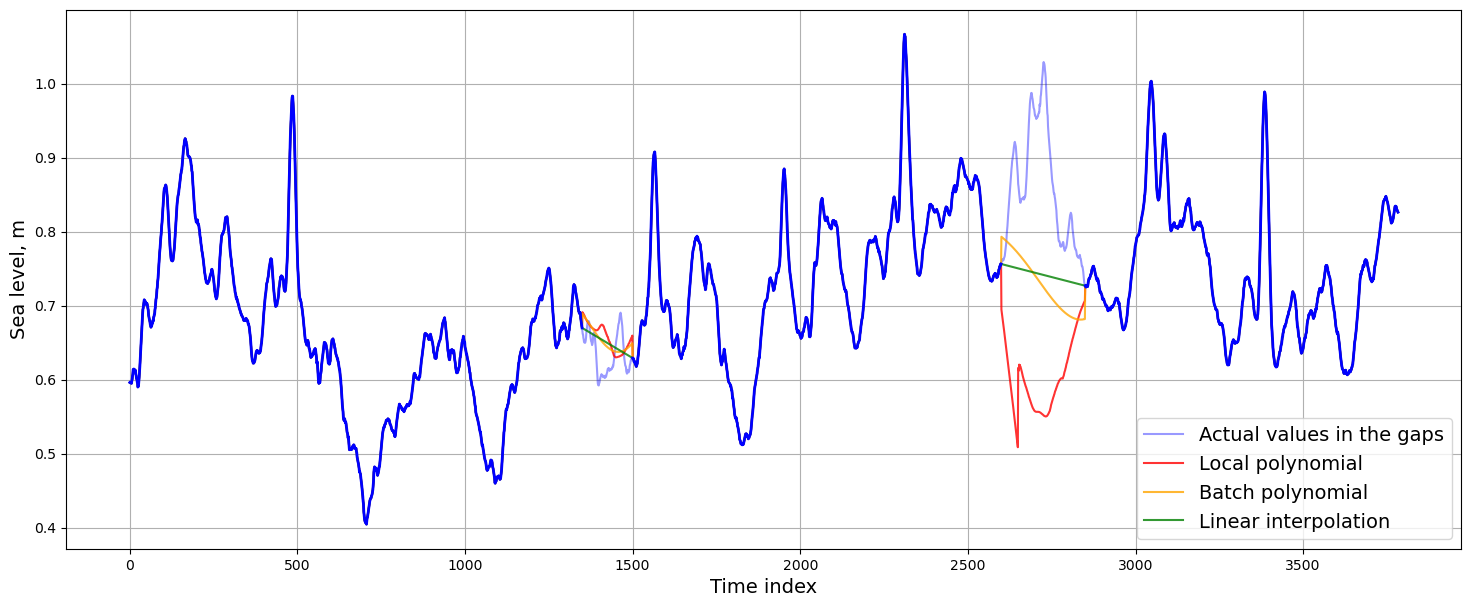

In [22]:
plt.plot(time_series, c='blue', alpha=0.4, label='Actual values in the gaps')
plt.plot(without_gap_poly_1, c='red', alpha=0.8, label='Local polynomial')
plt.plot(without_gap_poly_2, c='orange', alpha=0.8, label='Batch polynomial')
plt.plot(without_gap_linear, c='green', alpha=0.8, label='Linear interpolation')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()

In [23]:
# Function for creating pipeline
def get_simple_ridge_pipeline():
    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': 250}

    node_final = SecondaryNode('ridge', nodes_from=[node_lagged])
    pipeline = Pipeline(node_final)

    return pipeline

pipeline = get_simple_ridge_pipeline()
model_gapfiller = ModelGapFiller(gap_value=-100.0,
                                 pipeline=pipeline)

# Filling in the gaps
without_gap_forward = model_gapfiller.forward_filling(array_with_gaps)
without_gap_bidirect = model_gapfiller.forward_inverse_filling(array_with_gaps)

2024-07-01 13:14:00,183 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 324
2024-07-01 13:14:00,227 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 364
2024-07-01 13:14:00,290 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 324
2024-07-01 13:14:00,327 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 176
2024-07-01 13:14:00,352 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 364
2024-07-01 13:14:00,410 - LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 345


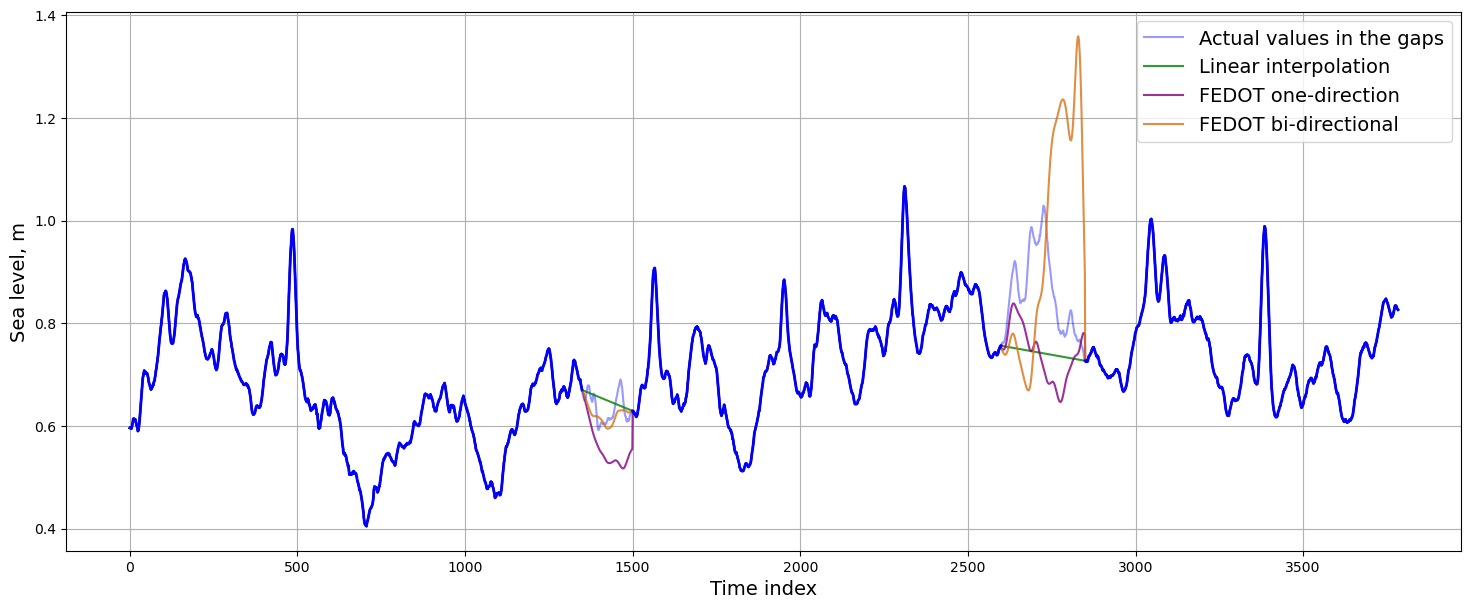

In [24]:
plt.plot(time_series, c='blue', alpha=0.4, label='Actual values in the gaps')
plt.plot(without_gap_linear, c='green', alpha=0.8, label='Linear interpolation')
plt.plot(without_gap_forward, c='purple', alpha=0.8, label='FEDOT one-direction')
plt.plot(without_gap_bidirect, c='#D77214', alpha=0.8, label='FEDOT bi-directional')
plt.plot(masked_array, c='blue', alpha=1.0, linewidth=2)
plt.ylabel('Sea level, m', fontsize=14)
plt.xlabel('Time index', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.show()